## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
from scipy.stats import spearmanr

from sklearn.model_selection import KFold
from sklearn.manifold import TSNE

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.optim import lr_scheduler
import torch.utils.data

import time
from tqdm import tqdm

from radam import RAdam
from text_data import TextDataset
from net import NeuralNet5
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from text_cleaning import clean_data
from word_embed import build_matrix_adv, get_word_lemma_dict
from sentence_embed import get_use_embedding_features
from create_features import get_dist_features, get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np
from inference import infer
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_colwidth',400)

Using TensorFlow backend.


## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv').fillna(' ')
train = pd.read_csv(f'{path}train.csv').fillna(' ')

In [3]:
train = clean_data(train, INPUTS)
test = clean_data(test,INPUTS)

In [4]:
init_seed()

In [5]:
%%time
use_feature_path = 'proc_data/use_embedding_features/'
embedding_train, embedding_test = get_use_embedding_features(train, test, INPUTS, use_feature_path)

CPU times: user 1.17 s, sys: 59.4 ms, total: 1.23 s
Wall time: 1.23 s


In [6]:
%%time
dist_features_train, dist_features_test  = get_dist_features(embedding_train, embedding_test)

CPU times: user 1.17 s, sys: 67.6 ms, total: 1.24 s
Wall time: 125 ms


In [7]:
tokenizer = Tokenizer()
full_text = []
for inp in INPUTS: full_text += list(train[inp])
for inp in INPUTS: full_text += list(test[inp])
tokenizer.fit_on_texts(full_text)

In [8]:
%%time
lemma_dict, word_dict = get_word_lemma_dict(full_text, 'proc_data/')

CPU times: user 25.8 ms, sys: 4.06 ms, total: 29.8 ms
Wall time: 24.4 ms


In [9]:
embed_size=300
embedding_path = 'pretrained_models/crawl-300d-2M.pkl'
embedding_path_spellcheck = 'pretrained_models/wiki-news-300d-1M.vec'

In [10]:
%%time
matrix_path = 'proc_data/embedding_matrix/'
embedding_matrix, nb_words, unknown_words = build_matrix_adv(
    embedding_path, embedding_path_spellcheck, word_dict, lemma_dict, 100000, embed_size, matrix_path)

CPU times: user 1.74 s, sys: 108 ms, total: 1.85 s
Wall time: 1.85 s


In [11]:
# tk.word_index = {k: v for k, v in tk.word_index.items() if k in word_dict.keys()}
# train['host'] = train['host'].apply(lambda x: x.split('.')[-2])
# test['host'] = test['host'].apply(lambda x: x.split('.')[-2])
train_host, test_host, host_dict, host_dict_reverse = get_categorical_features(train, test, 'host')
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [12]:
max_len = 512
max_len_title = 32
train_question_tokenized = pad_sequences(tokenizer.texts_to_sequences(train['question_body']), maxlen=max_len)
train_answer_tokenized = pad_sequences(tokenizer.texts_to_sequences(train['answer']), maxlen=max_len)
train_title_tokenized = pad_sequences(tokenizer.texts_to_sequences(train['question_title']),maxlen=max_len_title)

test_question_tokenized = pad_sequences(tokenizer.texts_to_sequences(test['question_body']), maxlen=max_len)
test_answer_tokenized = pad_sequences(tokenizer.texts_to_sequences(test['answer']), maxlen=max_len)
test_title_tokenized = pad_sequences(tokenizer.texts_to_sequences(test['question_title']), maxlen=max_len_title)

In [13]:
y = train[TARGETS].values

In [14]:
num_workers = 10
bs = 32
n_cat = len(category_dict) + 1
cat_emb = min(np.ceil((len(category_dict)) / 2), 50)
n_host = len(host_dict)+1
host_emb = min(np.ceil((len(host_dict)) / 2), 50)

In [15]:
bs_test = 8
test_loader = DataLoader(TextDataset(test_question_tokenized, test_answer_tokenized, test_title_tokenized,
                                     test_category, test_host, embedding_test, dist_features_test, test.index),
                          batch_size=bs_test, shuffle=False, num_workers=num_workers)

## Training model

In [16]:
lr = 0.001
loss_fn = nn.BCEWithLogitsLoss()
device = torch.device('cuda')
n_epochs = 10
model_name = 'net5'
checkpoint_dir = 'checkpoints/'
early_stopping = None

Fold 1 started at Sun Dec  1 22:54:17 2019
NeuralNet5(
  (embedding): Embedding(49311, 300)
  (embedding_dropout): SpatialDropout(p=0.3, inplace=False)
  (category_embedding): Embedding(6, 3)
  (host_embedding): Embedding(65, 32)
  (linear_q_add): Linear(in_features=300, out_features=256, bias=True)
  (linear_q_add1): Linear(in_features=256, out_features=64, bias=True)
  (bilinear_add): Bilinear(in1_features=64, in2_features=64, out_features=30, bias=True)
  (lstm_q): LSTM(300, 256, batch_first=True, bidirectional=True)
  (gru_q): GRU(512, 256, batch_first=True, bidirectional=True)
  (lstm_a): LSTM(300, 256, batch_first=True, bidirectional=True)
  (gru_a): GRU(512, 256, batch_first=True, bidirectional=True)
  (lstm_t): LSTM(300, 256, batch_first=True, bidirectional=True)
  (gru_t): GRU(512, 256, batch_first=True, bidirectional=True)
  (lstm_attention_q): Attention()
  (gru_attention_q): Attention()
  (lstm_attention_a): Attention()
  (gru_attention_a): Attention()
  (lstm_attention_t):

 53%|█████▎    | 53/100 [00:11<00:10,  4.67it/s]

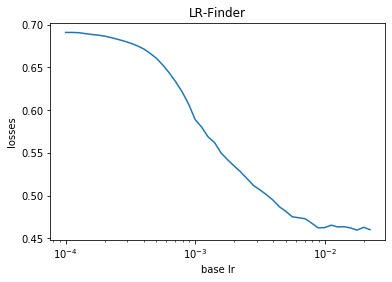

epoch 0: 	 Start training...



epoch 0/10 	 train : loss 0.62406 - spearmanr 0.031067
epoch 0: 	 Start validation...



epoch 0/10 	 valid : loss 0.4382 - spearmanr 0.12456
best model: epoch 0 - 0.12456
epoch 1: 	 Start training...



epoch 1/10 	 train : loss 0.40492 - spearmanr 0.21107
epoch 1: 	 Start validation...



epoch 1/10 	 valid : loss 0.39 - spearmanr 0.30568
best model: epoch 1 - 0.30568
epoch 2: 	 Start training...



epoch 2/10 	 train : loss 0.38552 - spearmanr 0.29904
epoch 2: 	 Start validation...



epoch 2/10 	 valid : loss 0.38758 - spearmanr 0.32758
best model: epoch 2 - 0.32758
epoch 3: 	 Start training...



epoch 3/10 	 train : loss 0.37721 - spearmanr 0.33403
epoch 3: 	 Start validation...



epoch 3/10 	 valid : loss 0.37853 - spearmanr 0.34646
best model: epoch 3 - 0.34646
epoch 4: 	 Start training...



epoch 4/10 	 train : loss 0.36993 - spearmanr 0.36147
epoch 4: 	 Start validation...



epoch 4/10 	 valid : loss 0.37815 - spearmanr 0.35421
best model: epoch 4 - 0.35421
epoch 5: 	 Start training...



epoch 5/10 	 train : loss 0.36243 - spearmanr 0.3944
epoch 5: 	 Start validation...



epoch 5/10 	 valid : loss 0.38243 - spearmanr 0.35729
best model: epoch 5 - 0.35729
epoch 6: 	 Start training...



epoch 6/10 	 train : loss 0.35445 - spearmanr 0.42151
epoch 6: 	 Start validation...



epoch 6/10 	 valid : loss 0.38168 - spearmanr 0.35946
best model: epoch 6 - 0.35946
epoch 7: 	 Start training...



epoch 7/10 	 train : loss 0.34597 - spearmanr 0.45234
epoch 7: 	 Start validation...



epoch 7/10 	 valid : loss 0.38249 - spearmanr 0.36009
best model: epoch 7 - 0.36009
epoch 8: 	 Start training...



epoch 8/10 	 train : loss 0.33873 - spearmanr 0.47357
epoch 8: 	 Start validation...



epoch 8/10 	 valid : loss 0.3853 - spearmanr 0.35837
model not improved for 1 epochs
epoch 9: 	 Start training...



epoch 9/10 	 train : loss 0.33408 - spearmanr 0.48825
epoch 9: 	 Start validation...



epoch 9/10 	 valid : loss 0.38648 - spearmanr 0.35692
model not improved for 2 epochs
TRAINING END: Best score achieved on epoch 7 - 0.36009
Starting inference for model: checkpoints/net5_fold_1_best.pth



Starting inference for model: checkpoints/net5_fold_1_best.pth



Fold 2 started at Sun Dec  1 23:00:52 2019
epoch 0: 	 Start training...



epoch 0/10 	 train : loss 0.54954 - spearmanr 0.056505
epoch 0: 	 Start validation...



epoch 0/10 	 valid : loss 0.41865 - spearmanr 0.23413
best model: epoch 0 - 0.23413
epoch 1: 	 Start training...



epoch 1/10 	 train : loss 0.3967 - spearmanr 0.25538
epoch 1: 	 Start validation...



epoch 1/10 	 valid : loss 0.38704 - spearmanr 0.31329
best model: epoch 1 - 0.31329
epoch 2: 	 Start training...



epoch 2/10 	 train : loss 0.38364 - spearmanr 0.31282
epoch 2: 	 Start validation...



epoch 2/10 	 valid : loss 0.37914 - spearmanr 0.33645
best model: epoch 2 - 0.33645
epoch 3: 	 Start training...



epoch 3/10 	 train : loss 0.3759 - spearmanr 0.34501
epoch 3: 	 Start validation...



epoch 3/10 	 valid : loss 0.38013 - spearmanr 0.35123
best model: epoch 3 - 0.35123
epoch 4: 	 Start training...



epoch 4/10 	 train : loss 0.36934 - spearmanr 0.37203
epoch 4: 	 Start validation...



epoch 4/10 	 valid : loss 0.3765 - spearmanr 0.3566
best model: epoch 4 - 0.3566
epoch 5: 	 Start training...



epoch 5/10 	 train : loss 0.36198 - spearmanr 0.4002
epoch 5: 	 Start validation...



epoch 5/10 	 valid : loss 0.37266 - spearmanr 0.36167
best model: epoch 5 - 0.36167
epoch 6: 	 Start training...



epoch 6/10 	 train : loss 0.35327 - spearmanr 0.42958
epoch 6: 	 Start validation...



epoch 6/10 	 valid : loss 0.37701 - spearmanr 0.3612
model not improved for 1 epochs
epoch 7: 	 Start training...



epoch 7/10 	 train : loss 0.3444 - spearmanr 0.45844
epoch 7: 	 Start validation...



epoch 7/10 	 valid : loss 0.37702 - spearmanr 0.36091
model not improved for 2 epochs
epoch 8: 	 Start training...



epoch 8/10 	 train : loss 0.33622 - spearmanr 0.48503
epoch 8: 	 Start validation...



epoch 8/10 	 valid : loss 0.37824 - spearmanr 0.36434
best model: epoch 8 - 0.36434
epoch 9: 	 Start training...



epoch 9/10 	 train : loss 0.33128 - spearmanr 0.49843
epoch 9: 	 Start validation...



epoch 9/10 	 valid : loss 0.38064 - spearmanr 0.36199
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 8 - 0.36434
Starting inference for model: checkpoints/net5_fold_2_best.pth



Starting inference for model: checkpoints/net5_fold_2_best.pth



Fold 3 started at Sun Dec  1 23:07:13 2019
epoch 0: 	 Start training...



epoch 0/10 	 train : loss 0.54311 - spearmanr 0.064523
epoch 0: 	 Start validation...



epoch 0/10 	 valid : loss 0.40744 - spearmanr 0.2311
best model: epoch 0 - 0.2311
epoch 1: 	 Start training...



epoch 1/10 	 train : loss 0.39711 - spearmanr 0.25723
epoch 1: 	 Start validation...



epoch 1/10 	 valid : loss 0.38555 - spearmanr 0.32265
best model: epoch 1 - 0.32265
epoch 2: 	 Start training...



epoch 2/10 	 train : loss 0.38553 - spearmanr 0.30492
epoch 2: 	 Start validation...



epoch 2/10 	 valid : loss 0.37987 - spearmanr 0.34267
best model: epoch 2 - 0.34267
epoch 3: 	 Start training...



epoch 3/10 	 train : loss 0.37601 - spearmanr 0.34175
epoch 3: 	 Start validation...



epoch 3/10 	 valid : loss 0.38088 - spearmanr 0.35968
best model: epoch 3 - 0.35968
epoch 4: 	 Start training...



epoch 4/10 	 train : loss 0.36909 - spearmanr 0.37166
epoch 4: 	 Start validation...



epoch 4/10 	 valid : loss 0.37972 - spearmanr 0.36522
best model: epoch 4 - 0.36522
epoch 5: 	 Start training...



epoch 5/10 	 train : loss 0.36217 - spearmanr 0.39732
epoch 5: 	 Start validation...



epoch 5/10 	 valid : loss 0.37428 - spearmanr 0.3659
best model: epoch 5 - 0.3659
epoch 6: 	 Start training...



epoch 6/10 	 train : loss 0.3546 - spearmanr 0.4245
epoch 6: 	 Start validation...



epoch 6/10 	 valid : loss 0.3737 - spearmanr 0.36963
best model: epoch 6 - 0.36963
epoch 7: 	 Start training...



epoch 7/10 	 train : loss 0.3453 - spearmanr 0.45716
epoch 7: 	 Start validation...



epoch 7/10 	 valid : loss 0.37753 - spearmanr 0.36973
best model: epoch 7 - 0.36973
epoch 8: 	 Start training...



epoch 8/10 	 train : loss 0.3373 - spearmanr 0.48075
epoch 8: 	 Start validation...



epoch 8/10 	 valid : loss 0.38022 - spearmanr 0.36785
model not improved for 1 epochs
epoch 9: 	 Start training...



epoch 9/10 	 train : loss 0.33303 - spearmanr 0.49243
epoch 9: 	 Start validation...



epoch 9/10 	 valid : loss 0.38142 - spearmanr 0.3682
model not improved for 2 epochs
TRAINING END: Best score achieved on epoch 7 - 0.36973
Starting inference for model: checkpoints/net5_fold_3_best.pth



Starting inference for model: checkpoints/net5_fold_3_best.pth



Fold 4 started at Sun Dec  1 23:13:36 2019
epoch 0: 	 Start training...



epoch 0/10 	 train : loss 0.55377 - spearmanr 0.055275
epoch 0: 	 Start validation...



epoch 0/10 	 valid : loss 0.41989 - spearmanr 0.22952
best model: epoch 0 - 0.22952
epoch 1: 	 Start training...



epoch 1/10 	 train : loss 0.39749 - spearmanr 0.25449
epoch 1: 	 Start validation...



epoch 1/10 	 valid : loss 0.38408 - spearmanr 0.32612
best model: epoch 1 - 0.32612
epoch 2: 	 Start training...



epoch 2/10 	 train : loss 0.38506 - spearmanr 0.3109
epoch 2: 	 Start validation...



epoch 2/10 	 valid : loss 0.38623 - spearmanr 0.34197
best model: epoch 2 - 0.34197
epoch 3: 	 Start training...



epoch 3/10 	 train : loss 0.37662 - spearmanr 0.34379
epoch 3: 	 Start validation...



epoch 3/10 	 valid : loss 0.3769 - spearmanr 0.34675
best model: epoch 3 - 0.34675
epoch 4: 	 Start training...



epoch 4/10 	 train : loss 0.37025 - spearmanr 0.36644
epoch 4: 	 Start validation...



epoch 4/10 	 valid : loss 0.37482 - spearmanr 0.35738
best model: epoch 4 - 0.35738
epoch 5: 	 Start training...



epoch 5/10 	 train : loss 0.36271 - spearmanr 0.39877
epoch 5: 	 Start validation...



epoch 5/10 	 valid : loss 0.37616 - spearmanr 0.35901
best model: epoch 5 - 0.35901
epoch 6: 	 Start training...



epoch 6/10 	 train : loss 0.35428 - spearmanr 0.42917
epoch 6: 	 Start validation...



epoch 6/10 	 valid : loss 0.3734 - spearmanr 0.36034
best model: epoch 6 - 0.36034
epoch 7: 	 Start training...



epoch 7/10 	 train : loss 0.34411 - spearmanr 0.46017
epoch 7: 	 Start validation...



epoch 7/10 	 valid : loss 0.37703 - spearmanr 0.35869
model not improved for 1 epochs
epoch 8: 	 Start training...



epoch 8/10 	 train : loss 0.3365 - spearmanr 0.48471
epoch 8: 	 Start validation...



epoch 8/10 	 valid : loss 0.38112 - spearmanr 0.35886
model not improved for 2 epochs
epoch 9: 	 Start training...



epoch 9/10 	 train : loss 0.33209 - spearmanr 0.49749
epoch 9: 	 Start validation...



epoch 9/10 	 valid : loss 0.38322 - spearmanr 0.35775
model not improved for 3 epochs
TRAINING END: Best score achieved on epoch 6 - 0.36034
Starting inference for model: checkpoints/net5_fold_4_best.pth



Starting inference for model: checkpoints/net5_fold_4_best.pth



Fold 5 started at Sun Dec  1 23:20:03 2019
epoch 0: 	 Start training...



epoch 0/10 	 train : loss 0.55398 - spearmanr 0.065033
epoch 0: 	 Start validation...



epoch 0/10 	 valid : loss 0.4118 - spearmanr 0.24466


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


best model: epoch 0 - 0.24466
epoch 1: 	 Start training...



epoch 1/10 	 train : loss 0.39575 - spearmanr 0.26353
epoch 1: 	 Start validation...



epoch 1/10 	 valid : loss 0.38835 - spearmanr 0.32046
best model: epoch 1 - 0.32046
epoch 2: 	 Start training...



epoch 2/10 	 train : loss 0.38453 - spearmanr 0.30941
epoch 2: 	 Start validation...



epoch 2/10 	 valid : loss 0.38612 - spearmanr 0.33987
best model: epoch 2 - 0.33987
epoch 3: 	 Start training...



epoch 3/10 	 train : loss 0.37624 - spearmanr 0.34149
epoch 3: 	 Start validation...



epoch 3/10 	 valid : loss 0.37943 - spearmanr 0.35735
best model: epoch 3 - 0.35735
epoch 4: 	 Start training...



epoch 4/10 	 train : loss 0.37018 - spearmanr 0.36935
epoch 4: 	 Start validation...



epoch 4/10 	 valid : loss 0.37883 - spearmanr 0.34765
model not improved for 1 epochs
epoch 5: 	 Start training...



epoch 5/10 	 train : loss 0.36275 - spearmanr 0.39709
epoch 5: 	 Start validation...



epoch 5/10 	 valid : loss 0.38262 - spearmanr 0.35851
best model: epoch 5 - 0.35851
epoch 6: 	 Start training...



epoch 6/10 	 train : loss 0.35495 - spearmanr 0.42439
epoch 6: 	 Start validation...



epoch 6/10 	 valid : loss 0.37599 - spearmanr 0.36202
best model: epoch 6 - 0.36202
epoch 7: 	 Start training...



epoch 7/10 	 train : loss 0.34639 - spearmanr 0.4508
epoch 7: 	 Start validation...



epoch 7/10 	 valid : loss 0.37885 - spearmanr 0.3656
best model: epoch 7 - 0.3656
epoch 8: 	 Start training...



epoch 8/10 	 train : loss 0.33751 - spearmanr 0.48051
epoch 8: 	 Start validation...



epoch 8/10 	 valid : loss 0.38194 - spearmanr 0.35865
model not improved for 1 epochs
epoch 9: 	 Start training...



epoch 9/10 	 train : loss 0.33318 - spearmanr 0.49501
epoch 9: 	 Start validation...



epoch 9/10 	 valid : loss 0.38244 - spearmanr 0.35712
model not improved for 2 epochs
TRAINING END: Best score achieved on epoch 7 - 0.36560
Starting inference for model: checkpoints/net5_fold_5_best.pth



Starting inference for model: checkpoints/net5_fold_5_best.pth



OOF score: 0.36251560216861606


In [17]:
folds = KFold(n_splits=5, random_state=42)
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds.split(train)):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(TextDataset(train_question_tokenized, train_answer_tokenized, 
                                          train_title_tokenized, train_category, train_host, embedding_train,
                                          dist_features_train, train_index, y),
                              batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=True)
    valid_loader = DataLoader(TextDataset(train_question_tokenized, train_answer_tokenized, 
                                          train_title_tokenized, train_category, train_host, embedding_train,
                                          dist_features_train, valid_index, y),
                              batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True)
        
    model = NeuralNet5(
        hidden_size=256, 
        max_len=max_len, 
        max_len_title=max_len_title,
        n_cat=n_cat, 
        cat_emb=cat_emb, 
        n_host=n_host, 
        host_emb=host_emb, 
        embedding_matrix=embedding_matrix
    )
    model.to(device)
    
    if fold_id == 0:
        print(model)
        if 1:
            optimizer = optim.Adam(model.parameters(), lr)
            lr_finder = LRFinder(n_iter=100, start_lr=1e-4, end_lr=10, device=device)
            lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
            plt.show()
    
    optimizer = optim.Adam(model.parameters(), lr)
    #scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=scheduler, 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None, 
        early_stopping=early_stopping, 
        batch_step_scheduler=True
    )
    
    learner.train()
    
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    
    test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
    preds += test_preds / folds.n_splits
    
print(f'OOF score: {spearmanr_np(oofs, y)}')
#0.3625

In [18]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [19]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.889410,0.598536,0.146230,0.669276,0.697448,0.738118,0.617610,0.534292,0.350059,0.005843,0.536145,0.604158,0.007855,0.025811,0.006410,0.016879,0.115338,0.068900,0.774449,0.000907,0.844508,0.894682,0.617546,0.947229,0.954415,0.804020,0.114785,0.049378,0.851931,0.908264
1,46,0.889624,0.551640,0.000692,0.758605,0.893479,0.964454,0.551176,0.453062,0.207641,0.000933,0.285271,0.415382,0.000408,0.000424,0.000175,0.007786,0.921394,0.224133,0.086439,0.000048,0.749007,0.931142,0.625404,0.966396,0.972730,0.847389,0.904623,0.132668,0.061386,0.879996
2,70,0.930838,0.711518,0.004332,0.952413,0.910838,0.989045,0.598162,0.486267,0.102606,0.001040,0.151325,0.809572,0.002428,0.005979,0.005335,0.004269,0.151383,0.024360,0.335406,0.000274,0.845420,0.945676,0.663180,0.980471,0.981796,0.884934,0.063419,0.019963,0.815770,0.923482
3,132,0.809320,0.397142,0.005257,0.722506,0.853382,0.928764,0.500392,0.407805,0.163778,0.004032,0.359759,0.172951,0.008981,0.001837,0.004043,0.011454,0.700050,0.159367,0.512479,0.000352,0.681452,0.931356,0.684248,0.964152,0.980802,0.866941,0.722309,0.166045,0.637736,0.898143
4,200,0.926403,0.541880,0.012852,0.886734,0.728337,0.895549,0.596801,0.529250,0.236325,0.001753,0.486634,0.829371,0.005606,0.005164,0.001036,0.056178,0.389595,0.106389,0.160105,0.000376,0.765755,0.957168,0.678239,0.981449,0.984354,0.889197,0.369978,0.097960,0.439536,0.921615


## Trained categorical encodings visualization

Just a fun visualization showing how trained categorical embeddings look like.

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 65 / 65
[t-SNE] Mean sigma: 5.973502
[t-SNE] KL divergence after 250 iterations with early exaggeration: 42.669593
[t-SNE] KL divergence after 950 iterations: 0.648994


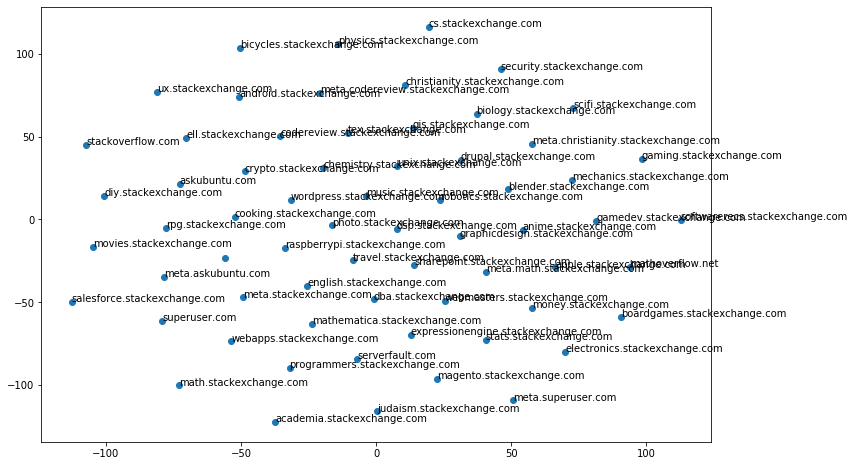

In [20]:
a = list(model.children())
g = a[3].weight.cpu().detach().numpy()
tsne = TSNE(n_components=2, verbose=1, perplexity=60, n_iter=1000, method='exact')
tsne_results = tsne.fit_transform(g)
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(tsne_results[:, 0], tsne_results[:, 1])

for i, txt in enumerate(host_dict.values()):
    ax.annotate(txt, (tsne_results[i, 0], tsne_results[i, 1]))

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 6 / 6
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.983474
[t-SNE] KL divergence after 1000 iterations: 0.130989


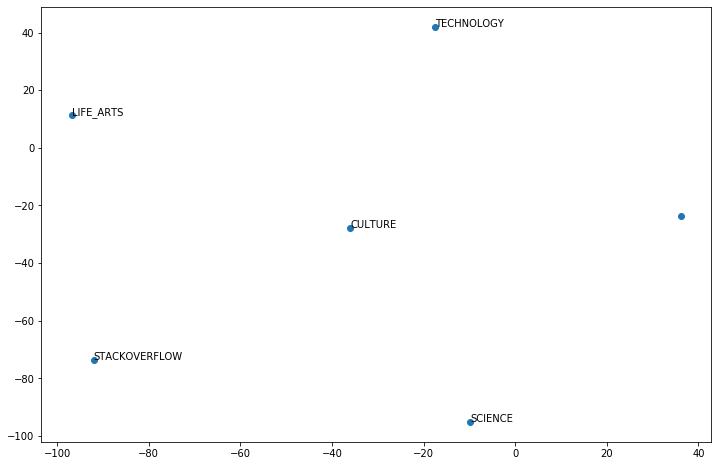

In [21]:
g = a[2].weight.cpu().detach().numpy()
tsne = TSNE(n_components=2, verbose=1, perplexity=60, n_iter=1000, method='exact')
tsne_results = tsne.fit_transform(g)
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(tsne_results[:, 0], tsne_results[:, 1])

for i, txt in enumerate(category_dict.values()):
    ax.annotate(txt, (tsne_results[i, 0], tsne_results[i, 1]))